In [1]:
import cv2
import copy
import numpy as np

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from torchvision import models as torch_models

%matplotlib inline
import matplotlib.pyplot as plt

seed = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
dset = []
filenames = []
! unzip -qn EyesDataset.zip
for file in Path('EyesDataset').iterdir():
    filenames.append(str(file))
    img = cv2.imread(str(file))
    dset.append(img)
    
dset = np.array(dset, dtype='f4') / 255
dset_flat = dset.reshape(len(dset), -1)

0.4735


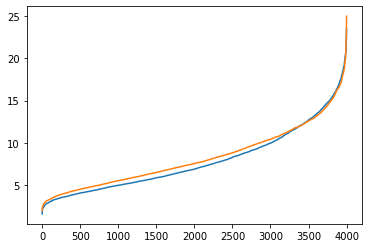

In [27]:
kmeans = KMeans(n_clusters=2, random_state=seed).fit(dset_flat)
dist = kmeans.transform(dset_flat)

plt.plot(np.sort(dist[:, 0]));
plt.plot(np.sort(dist[:, 1]));

labels = kmeans.labels_ 
print(labels.sum()/labels.size)

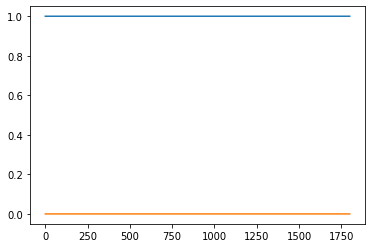

In [28]:
n_samples = 1800
ids1 = np.argsort(dist[:,1] - dist[:,0])[:n_samples]
ids0 = np.argsort(dist[:,0] - dist[:,1])[:n_samples]

plt.plot(labels[ids1]);
plt.plot(labels[ids0]);

In [29]:
# train_imgs, test_imgs = train_test_split(filenames, test_size=200/len(labels))

In [14]:
X = dset.transpose(0, 3, 1, 2)
y = labels

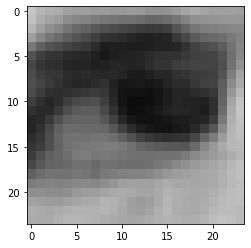

In [15]:
mask1 = y.astype('bool')
plt.imshow(dset[~mask1][32]);

In [16]:
X_train, X_test, y_train, y_test = map(torch.Tensor,
    train_test_split(X, y, test_size=.2, random_state=seed))

In [10]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 32, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                32, 16, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                16, 8, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                8, 4, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(4, 1, kernel_size=2)
        )
        
    def forward(self, X):
        return self.main(X).flatten()
    
    def predict(self, X):
        return self.forward(X).sigmoid()

In [11]:
class BatchLoader:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.bs = batch_size
        self.gen = None

    def _gen(self):
        ids = np.arange(len(self.y))
        np.random.shuffle(ids)

        for i in range(0, len(self.y), self.bs):
            yield self.X[i:i+self.bs], self.y[i:i+self.bs]

    def reinit(self):
        self.gen = self._gen()

In [21]:
A.shape

(3200, 3, 24, 24)

In [12]:
def ROC_EER(y_true, y_pred, return_roc=False):
    if isinstance(y_pred, torch.Tensor):
        y_true = y_true.cpu()
        y_pred = y_pred.detach().cpu()
        
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    eer = fpr[np.nanargmin(np.absolute(1 - tpr - fpr))]
    if return_roc: return eer, fpr, tpr
    return eer

In [53]:
def train(
    net, criterion, optimizer, train_bl, val_bl,
    scheduler=None, epochs=10, verbose=True,
    validation='EER', best_val_score=None):

    if verbose:
        print('Epoch\t\tTrain\t\tValidation')
        if validation == 'EER': print('\t\t\t\tBCE\tEER')
        print()
        
    if best_val_score is None:
        best_val_score = float('inf')
        best_model_state = None

    for epoch in range(1, epochs+1):
        train_loss = val_loss = 0
        net.train()

        train_bl.reinit()
        val_bl.reinit()

        for X,y in train_bl.gen:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device)
            
            loss = criterion(net(X), y)
            loss.backward()
            train_loss += loss.item() * len(y)/len(train_bl.y)

            optimizer.step()

        net.eval()
        for X,y in val_bl.gen:
            X, y = X.to(device), y.to(device)

            y_pred = net(X)
            loss = criterion(y_pred, y)

            val_loss += loss.item() * len(y)/len(val_bl.y)
            eer = ROC_EER(val_bl.y, net(val_bl.X))
            
            val_score = eer if validation == 'EER' else val_loss
            
        if val_score < best_val_score:
            best_val_score = val_score
            best_model_state = copy.deepcopy(net.state_dict())

        if scheduler is not None: scheduler.step()

        freq = max(epochs//20, 1)
        if verbose and epoch % freq == 0:
            logline = f'{epoch}/{epochs}\t\t{train_loss:.4}\t\t{val_loss:.4f}'
            if validation == 'EER': logline += f'\t{eer:.4}'
            print(logline)
            
    return best_val_score, best_model_state

In [54]:
class LabelSmoothedBCEwLL(nn.BCEWithLogitsLoss):
    """
    In this implementation, the effect of label smoothing is
    taken into account in the regularization term. This loss
    is completely equivalent to the actual label smoothing
    implemented below, when the hyperparmeter epsilon is
    twice as the commented out one.
    """
    def __init__(self, eps=.2):
        super().__init__()
        self.eps = eps
        
    def forward(self, input, target):
        base_loss = super().forward(input, target)
        dummy_target = torch.empty_like(target).fill_(.5)
        reg_term = super().forward(input, dummy_target)
        return (1-self.eps)*base_loss + self.eps*reg_term

# class LabelSmoothedBCEwLL(nn.BCEWithLogitsLoss):
#     def __init__(self, eps=.1):
#         super().__init__()
#         self.eps = eps
        
#     def forward(self, input, target):
#         target = target.clone()
#         target[np.where(target == 0)] = self.eps
#         target[np.where(target == 1)] = 1 - self.eps
#         return super().forward(input, target)

In [67]:
label_smoothing = True

net = SimpleNet().to(device)
opt = optim.Adam(net.parameters(), lr=3e-3)

criterion = nn.BCEWithLogitsLoss()
if label_smoothing:
    criterion = LabelSmoothedBCEwLL(.4)

train_bl = BatchLoader(X_train, y_train, 40)
val_bl = BatchLoader(X_test, y_test, 100)

SAVE = False
LOAD = True

In [68]:
score, state = train(net, criterion, opt, train_bl, val_bl, epochs=10, validation='EER')
if SAVE: torch.save(state, 'weights.pth')

Epoch		Train		Validation
				BCE	EER

1/10		0.5477		0.5316	0.02582
2/10		0.5372		0.5254	0.01643
3/10		0.5359		0.5246	0.01643
4/10		0.5347		0.5238	0.01408
5/10		0.5337		0.5227	0.01643
6/10		0.5329		0.5216	0.01643
7/10		0.5321		0.5211	0.01643
8/10		0.5314		0.5204	0.01408
9/10		0.5306		0.5201	0.01408
10/10		0.5299		0.5193	0.01408


In [69]:
if LOAD:
    net = SimpleNet()
    net.load_state_dict(
        torch.load('weights.pth', map_location=device))

In [70]:
y_pred = net.predict(X_test)
eer, fpr, tpr = ROC_EER(y_test, y_pred, return_roc=True)

EER = 0.009389671361502348


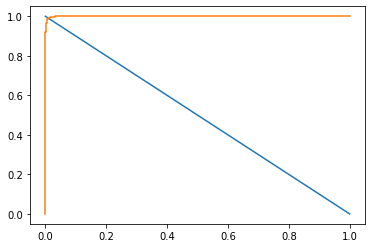

In [71]:
x = np.linspace(0, 1, num=len(fpr))
print('EER =', eer)

plt.plot(x, 1-x);
plt.plot(fpr, tpr);